# Collaborative Recommendation Systems based on User-User Cosine Similarity Matrix

Outline
- Loading movies, users and ratings files
- Create movie vectors
- Compute  similarity matrix by calculating cosine similarity 
- Test Recommendations

In [69]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [70]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
import altair as alt
import datapane as dp
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

## Read users,ratings and movies files

In [72]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/movieLense'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

In [73]:
# Utility function to read files
def read_file(file_name):
    return pd.read_csv(open(f"{input_file_path}/{file_name}", 'r'))

In [74]:
# Utility function to Write files
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [75]:
import re

def remove_special_characters(text):
    '''Function to clean up any given text by removing non alphanumeric characters with spaces'''
    # Define a pattern to keep only alphanumeric characters
    pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Use the pattern to replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

### Users

In [76]:
users = read_file('users.csv')

In [77]:
users.head()

,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Ratings

In [78]:
ratings = read_file('ratings_short.csv')

In [79]:
ratings.head()

,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
1,2,1,tt0114709,4
2,5,1,tt0114709,4
3,6,1,tt0114709,4
4,10,1,tt0114709,4


### Movies

In [80]:
movies = read_file('movies_combined.csv')

In [81]:
movies.head()

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""..."
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B..."
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ..."
3,4,Get Shorty,1995,tt0113161,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri..."
4,5,Copycat,1995,tt0112722,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,"[{""category"":""composer"",""crew_name"":""Christoph..."


In [82]:
movies['cleaned_title'] = movies['title'].apply(lambda x:x.lower()).apply(remove_special_characters).str.replace(" ","")

In [83]:
movies.head(3)

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...",toystory
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",fourrooms


### Basic checks

In [84]:
# Check for the shape of each users, item(movies) and ratings
users.shape
ratings.shape
movies.shape

(943, 5)

(99383, 4)

(1663, 26)

In [85]:
# Check for duplications
users.duplicated().sum()
ratings.duplicated().sum()
movies.duplicated().sum()

0

0

0

In [86]:
ratings

,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
1,2,1,tt0114709,4
2,5,1,tt0114709,4
3,6,1,tt0114709,4
4,10,1,tt0114709,4
...,...,...,...,...
99378,854,1677,tt0100724,3
99379,863,1678,tt0119711,1
99380,863,1679,tt0016122,3
99381,896,1681,tt0111804,3


## Concept
- User-User Similarity Matrix
    - To implement user-based collaborative filtering, a user-user similarity matrix is created. This matrix measures the similarity between users based on their preferences.

- We want to create a user vector matrix representing movie ratings
    - The user-item matrix (also known as the utility matrix) represents the interactions between users and items. - Each entry in the matrix corresponds to the rating or preference that a user has given to an item. 
    - Rows typically represent users, and columns represent items.

|    |movie1|movie2|movie3|movie4|...|movie1663|
|----|-----|-----|-----|-----|---|-------|
|user1|5|2|0|1|...|3|
|user2|0|4|1|3|...|1|
|user3|3|2|1|5|...|0|
|user943|3|2|1|5|...|0|

- We will then find the distance of each movie from other movies using cosine similarity 
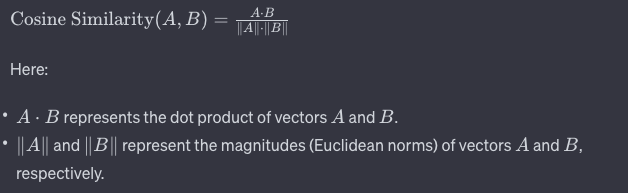

- In the context of item-item similarity in recommendation systems:

    -  Each user row corresponds to a vector representing movie ratings.
    -  The dot product of two user vectors measures the similarity in terms of movie preferences.
    -  The magnitude of each user vector represents the "length" of the preferences.
        - The length of the preference vector reflects the strength or intensity of the preferences. 
        - Larger magnitudes indicate a stronger preference, while smaller magnitudes suggest weaker preferences.
    -  When calculating cosine similarity, the length of the preference vectors is used to normalize the dot product, ensuring that the similarity score is not biased by the overall intensity of preferences. 
    - The normalization helps focus on the direction of preferences rather than their absolute magnitudes.

In [87]:
# Check the number of ratings given by each user
ratings.groupby('user_id').count()['rating']

user_id
1      270
2       61
3       51
4       23
5      174
      ... 
939     48
940    107
941     22
942     77
943    168
Name: rating, Length: 943, dtype: int64

In [88]:
# Lets check the minimum number of movies rated
ratings.groupby('user_id').count()['rating'].min()
ratings.groupby('user_id').count()['rating'].max()

19

735

In [89]:
# Check the number of ratings given for each movie
ratings.groupby('movie_id').count()['rating']

movie_id
1       452
2       131
3        90
4       209
5        86
       ... 
1677      1
1678      1
1679      1
1681      1
1682      1
Name: rating, Length: 1663, dtype: int64

In [90]:
ratings.groupby('movie_id').count()['rating'].min()
ratings.groupby('movie_id').count()['rating'].max()

1

583

In [91]:
ratings.shape

(99383, 4)

## Create User vectors

In [92]:
# Pivot the ratings table to get movie vectors
ratings_pt = ratings.pivot_table(index='user_id',columns='movie_id',values='rating')

In [93]:
ratings_pt.shape

(943, 1663)

In [94]:
ratings_pt.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.000,3.000,4.000,3.000,3.000,5.000,4.000,1.000,5.000,3.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.000,3.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.000,NaN,NaN,NaN,NaN,NaN,2.000,4.000,4.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5.000,NaN,NaN,5.000,5.000,5.000,4.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.000,4.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
ratings_pt_index = list(enumerate(ratings_pt.index))

In [96]:
ratings_pt_index

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 20),
 (20, 21),
 (21, 22),
 (22, 23),
 (23, 24),
 (24, 25),
 (25, 26),
 (26, 27),
 (27, 28),
 (28, 29),
 (29, 30),
 (30, 31),
 (31, 32),
 (32, 33),
 (33, 34),
 (34, 35),
 (35, 36),
 (36, 37),
 (37, 38),
 (38, 39),
 (39, 40),
 (40, 41),
 (41, 42),
 (42, 43),
 (43, 44),
 (44, 45),
 (45, 46),
 (46, 47),
 (47, 48),
 (48, 49),
 (49, 50),
 (50, 51),
 (51, 52),
 (52, 53),
 (53, 54),
 (54, 55),
 (55, 56),
 (56, 57),
 (57, 58),
 (58, 59),
 (59, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (64, 65),
 (65, 66),
 (66, 67),
 (67, 68),
 (68, 69),
 (69, 70),
 (70, 71),
 (71, 72),
 (72, 73),
 (73, 74),
 (74, 75),
 (75, 76),
 (76, 77),
 (77, 78),
 (78, 79),
 (79, 80),
 (80, 81),
 (81, 82),
 (82, 83),
 (83, 84),
 (84, 85),
 (85, 86),
 (86, 87),
 (87, 88),
 (88, 89),
 (89, 90),
 (90, 91),
 (91, 92),
 (92, 9

In [97]:
# fillna values with 0
ratings_pt.fillna(0,inplace=True)

In [98]:
ratings_pt.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.000,3.000,4.000,3.000,3.000,5.000,4.000,1.000,5.000,3.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,4.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [99]:
ratings_pt.loc[1]

movie_id
1      5.000
2      3.000
3      4.000
4      3.000
5      3.000
        ... 
1677   0.000
1678   0.000
1679   0.000
1681   0.000
1682   0.000
Name: 1, Length: 1663, dtype: float64

## Compute cosine similarity score

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

In [101]:
# Calculate the cosine similarity of each movie against all movies
# The values in the matrix represent the similarity between items. Again, diagonal elements are usually set to 1
similarity = cosine_similarity(ratings_pt)

In [102]:
similarity.shape

(943, 943)

In [103]:
#Check for an index values for cosine similarity score
similarity

array([[1.        , 0.16927963, 0.03834972, ..., 0.14938879, 0.18298739,
        0.40024267],
       [0.16927963, 1.        , 0.09706862, ..., 0.16291072, 0.16221306,
        0.10673209],
       [0.03834972, 0.09706862, 1.        , ..., 0.10486331, 0.12551515,
        0.02750559],
       ...,
       [0.14938879, 0.16291072, 0.10486331, ..., 1.        , 0.10307665,
        0.09511958],
       [0.18298739, 0.16221306, 0.12551515, ..., 0.10307665, 1.        ,
        0.18504047],
       [0.40024267, 0.10673209, 0.02750559, ..., 0.09511958, 0.18504047,
        1.        ]])

In [104]:
similarity[3]

array([0.06648443, 0.15310468, 0.33343036, 1.        , 0.03283424,
       0.05730374, 0.09410511, 0.19327073, 0.10408973, 0.0625454 ,
       0.10764782, 0.0774113 , 0.11316946, 0.07262769, 0.1310781 ,
       0.08730488, 0.05538806, 0.03656788, 0.16431899, 0.08896287,
       0.19558489, 0.08458386, 0.06363796, 0.18033131, 0.08644269,
       0.15551429, 0.07635379, 0.15656299, 0.10884801, 0.14852043,
       0.04379768, 0.13939725, 0.35719161, 0.15631984, 0.21080547,
       0.06933457, 0.11464547, 0.06711629, 0.23450306, 0.20285997,
       0.06995121, 0.07234385, 0.1649678 , 0.12338944, 0.06811848,
       0.18410737, 0.22029404, 0.09551122, 0.08765104, 0.14635585,
       0.09744268, 0.05415443, 0.09133587, 0.17579598, 0.05759242,
       0.10696197, 0.14649489, 0.08288271, 0.06674813, 0.05803126,
       0.28840522, 0.09290456, 0.16312692, 0.10540091, 0.13001186,
       0.22517034, 0.        , 0.15702495, 0.13431265, 0.08377192,
       0.06853923, 0.0552456 , 0.06011301, 0.26431673, 0.08273

In [105]:
similar_users = sorted(list(enumerate(similarity[8])),reverse=True,key=lambda x:x[1])[1:30]
similar_users

[(734, 0.2364234533024243),
 (432, 0.23281854889379824),
 (796, 0.22976150005602325),
 (679, 0.22745261897272367),
 (358, 0.2272753288229391),
 (739, 0.2252828909446542),
 (729, 0.22511406984188842),
 (219, 0.21728536995283573),
 (122, 0.21721394560069668),
 (595, 0.2151904201570202),
 (742, 0.20352289460267364),
 (31, 0.2027024596957781),
 (593, 0.20133813719492435),
 (67, 0.20081398469021833),
 (889, 0.19938427267659292),
 (9, 0.19822253294019987),
 (743, 0.19761904761904764),
 (568, 0.19691594286247913),
 (481, 0.1967672683931611),
 (604, 0.19589524964480776),
 (596, 0.1933898505898216),
 (198, 0.1930871454944618),
 (78, 0.19061847687647723),
 (650, 0.19028109877684685),
 (396, 0.19007131817491293),
 (323, 0.18994814762503254),
 (656, 0.18887296662759473),
 (830, 0.18796834558316308),
 (833, 0.18704405538900382)]

## Test recommendations
Predictions are made by considering the preferences for similar items

In [106]:
def recommend_to_user(user_id):
    '''Function to recommend movies based on title '''
    # Clean the input movie title

    # Search the title in the new dataframe
    try:
        index = user_id
        # Get the cosine distance of this movie with respect to other movies from similarity matrix computed above
        distances = similarity[index]
        # Sort the distances in ascending order and select first 5 movies closet to the movies
        similar_users = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:30]
        users=[]
        for u_touple in similar_users:
            # Append users only if Cosine Similarity > 0.3
            if u_touple[1] > 0.3:
                # print("score - " + str(u_touple[1]))
                users.append(u_touple[0])
        if users == []:
            print("No users matching with similarity score > 0.3")
        else:
            movies_watched_by_other_similar_users = ratings[ratings['user_id'].isin(users)]
            rated_movies = ratings[ratings.user_id == user_id]["imdb_id"].values
            movies_filtered =  movies_watched_by_other_similar_users[movies_watched_by_other_similar_users.imdb_id.apply(lambda imdb_id: imdb_id not in rated_movies)]
            unique_values_list = movies_filtered['imdb_id'].unique().tolist()
            return unique_values_list[:6]
    except:
        print("User not found in DB - " + str(user_id))
        return None

In [107]:
user_id = 67
movie_list=recommend_to_user(user_id)
movie_list

['tt0097446', 'tt0113101', 'tt0113161', 'tt0112722', 'tt0115012', 'tt0004931']

In [108]:
# Movies rated by this user
rated_movies = ratings[ratings.user_id == user_id]["imdb_id"].values
movies[movies['imdb_id'].isin(rated_movies)]

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...",toystory
6,7,Twelve Monkeys,1995,tt0116479,0,0,0,0,0,0,...,0,0,0,1,0,0,0,NaN,"[{""category"":""actor"",""crew_name"":""Keith Fulton...",twelvemonkeys
23,24,Rumble in the Bronx,1996,tt0113326,0,1,1,0,0,0,...,0,0,0,0,0,0,0,"Ma Hon Keung , a Hong Kong cop comes to New Yo...","[{""category"":""composer"",""crew_name"":""Nathan Wa...",rumbleinthebronx
24,25,"Birdcage, The",1996,tt0115685,0,0,0,0,0,1,...,0,0,0,0,0,0,0,Val Goldman and Barbara Keeley are engaged to ...,"[{""category"":""writer"",""crew_name"":""Elaine May""...",birdcagethe
63,64,"Shawshank Redemption, The",1994,tt0111161,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"In 1947, banker Andy Dufresne is convicted of...","[{""category"":""editor"",""crew_name"":""Richard Fra...",shawshankredemptionthe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,871,Vegas Vacation,1997,tt0120434,0,0,0,0,0,1,...,0,0,0,0,0,0,0,"At work, Clark Griswold has invented a long l...","[{""category"":""cinematographer"",""crew_name"":""Wi...",vegasvacation
1036,1047,Multiplicity,1996,tt0117108,0,0,0,0,0,1,...,0,0,0,0,0,0,0,Doug Kinney is a Los Angeles construction wor...,"[{""category"":""producer"",""crew_name"":""Trevor Al...",multiplicity
1041,1052,Dracula: Dead and Loving It,1995,tt0112896,0,0,0,0,0,1,...,0,0,0,0,0,0,0,The year is 1893: solicitor Thomas Renfield t...,"[{""category"":""editor"",""crew_name"":""Adam Weiss""...",draculadeadandlovingit
1082,1093,Live Nude Girls,1996,tt0113674,0,0,0,0,0,1,...,0,0,0,0,0,0,0,A group of childhood friends have a sleepover ...,"[{""category"":""cinematographer"",""crew_name"":""Ch...",livenudegirls


In [109]:
# Movies recommended to this user
recomm_movies=movies[movies['imdb_id'].isin(movie_list)]

In [110]:
recomm_movies

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",fourrooms
3,4,Get Shorty,1995,tt0113161,0,1,0,0,0,1,...,0,0,0,0,0,0,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri...",getshorty
4,5,Copycat,1995,tt0112722,0,0,0,0,0,0,...,0,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,"[{""category"":""composer"",""crew_name"":""Christoph...",copycat
5,6,Shanghai Triad,1995,tt0115012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Shanghai Triad takes place over the course of ...,"[{""category"":""producer"",""crew_name"":""Yigong Wu...",shanghaitriad
7,8,Babe,1995,tt0004931,0,0,0,0,1,1,...,0,0,0,0,0,0,0,NaN,"[{""category"":""actor"",""crew_name"":""Oliver Hardy...",babe


In [111]:
m_list = []
for index,row in recomm_movies.iterrows():
    new_list = {'imdb_id': row['imdb_id'],
                'title': row['title']}
    m_list.append(new_list)
print(m_list)

[{'imdb_id': 'tt0097446', 'title': 'GoldenEye '}, {'imdb_id': 'tt0113101', 'title': 'Four Rooms '}, {'imdb_id': 'tt0113161', 'title': 'Get Shorty '}, {'imdb_id': 'tt0112722', 'title': 'Copycat '}, {'imdb_id': 'tt0115012', 'title': 'Shanghai Triad '}, {'imdb_id': 'tt0004931', 'title': 'Babe '}]


In [112]:
movie_list

['tt0097446', 'tt0113101', 'tt0113161', 'tt0112722', 'tt0115012', 'tt0004931']

## Save Models

In [113]:
import pickle
pickle.dump(similarity,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/collab_filtering_user_user_similarity/collab_similarity.pkl','wb'))

In [114]:
pickle.dump(ratings_pt_index,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/collab_filtering_user_user_similarity/collab_ratings_pt_indexes.pkl','wb'))

In [115]:
pickle.dump(ratings_pt,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/collab_filtering_user_user_similarity/collab_ratings_pt.pkl','wb'))